In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid", palette="muted", color_codes=True)

df = pd.read_csv("owid_covid_data_us_subset.csv")

df.head()

In [ ]:
#Function to find precision, recall, and F1 score
def pre_rec_f1(y_pred, y):
    eps = np.finfo(float).eps
    num_cls = len(np.unique(y))
    tp_sum, fp_sum, fn_sum, f1_sum = 0, 0, 0, 0
    tps, fps, fns, pre, rec, f1s = [], [], [], [], [], []
    for i in range(num_cls):
        y_pred_i = y_pred == i
        y_i = y == i
        tp = np.logical_and(y_pred_i, y_i).sum()
        fp = np.logical_and(y_pred_i, (~y_i)).sum()
        fn = np.logical_and((~y_pred_i), y_i).sum()
        tp_sum += tp
        fp_sum += fp
        fn_sum += fn
        f1 = (2 * tp) / (2 * tp + fp + fn + eps)
        f1_sum += f1
        pre.append(tp / (tp + fp + eps))
        rec.append(tp / (tp + fn + eps))
        tps.append(tp)
        fps.append(fp)
        fns.append(fn)
        f1s.append(f1)

    macrof1 = f1_sum / (num_cls + eps)
    microf1 = (2 * tp_sum) / (2 * tp_sum + fp_sum + fn_sum + eps)
    return macrof1, microf1, tps, fps, fns, pre, rec, f1s


### Task 1: Data Cleaning and Exploratory Analysis.
- Cleaning missing values, removing duplicates, and standardizing formats on original data and original data set.
- Exploratory analysis to identify trends, patterns, and anomalies.
- Visualization using Matplotlib and Seaborn.
- Line charts for time-series trends in total_cases, total_deaths, and hospitalization_rate.
- Histograms and boxplots for ICU rates and hospitalization distributions.
- Use StandardScaler to normalize the features before applying a classifier.

In [ ]:
#Code for task 1
# Data Cleaning and Initial Analysis
# Check missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Remove duplicates
df = df.drop_duplicates()
print("\nShape after removing duplicates:", df.shape)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Basic statistics
print("\nBasic statistics of numerical columns:")
print(df.describe())

# Time series visualization
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(df['date'], df['total_cases'], 'b-', label='Total Cases')
plt.title('COVID-19 Total Cases Over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(df['date'], df['total_deaths'], 'r-', label='Total Deaths')
plt.title('COVID-19 Total Deaths Over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df['date'], df['hosp_patients'], 'g-', label='Hospitalized Patients')
plt.title('COVID-19 Hospitalization Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='icu_patients', bins=30)
plt.title('Distribution of ICU Patients')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='hosp_patients')
plt.title('Boxplot of Hospitalized Patients')

plt.tight_layout()
plt.show()

# Feature scaling
numeric_columns = ['total_cases', 'total_deaths', 'hosp_patients', 'icu_patients']
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print("\nScaled data summary:")
print(df_scaled[numeric_columns].describe())

### Task 2: Correlation and Statistical Analysis (Data subset)
- Compute Pearson correlation coefficients between numerical variables, focusing on icu_requirement and other derived features.
- Create a heatmap to visualize the full correlation matrix, highlighting features with strong relationships (e.g., correlations > ±0.5)
- Scatter plots with regression lines for correlated features.
- Use Chi-Square tests to examine associations between categorical variables
- Tables summarizing ANOVA/Kruskal-Wallis results, with p-values and effect sizes for key variables.


In [ ]:
#Code for task 2
# Import additional required libraries
from scipy import stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency, f_oneway, kruskal

# Select numerical columns for correlation analysis
numeric_cols = ['total_cases', 'total_deaths', 'hosp_patients', 'icu_patients']

# Compute correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0)
plt.title('Correlation Matrix of COVID-19 Metrics')
plt.tight_layout()
plt.show()

# Create scatter plots for highly correlated features
plt.figure(figsize=(15, 5))

# Scatter plot: Total Cases vs Total Deaths
plt.subplot(1, 3, 1)
sns.regplot(data=df, x='total_cases', y='total_deaths', scatter_kws={'alpha':0.5})
plt.title('Total Cases vs Total Deaths')

# Scatter plot: Total Cases vs Hospitalized Patients
plt.subplot(1, 3, 2)
sns.regplot(data=df, x='total_cases', y='hosp_patients', scatter_kws={'alpha':0.5})
plt.title('Total Cases vs Hospitalized Patients')

# Scatter plot: Hospitalized Patients vs ICU Patients
plt.subplot(1, 3, 3)
sns.regplot(data=df, x='hosp_patients', y='icu_patients', scatter_kws={'alpha':0.5})
plt.title('Hospitalized vs ICU Patients')

plt.tight_layout()
plt.show()

# Statistical Tests
print("\nStatistical Analysis Results:")
print("-" * 50)

# Create binary categories for chi-square test
df['high_cases'] = df['total_cases'] > df['total_cases'].median()
df['high_deaths'] = df['total_deaths'] > df['total_deaths'].median()

# Chi-square test
contingency_table = pd.crosstab(df['high_cases'], df['high_deaths'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test (High Cases vs High Deaths):")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")

# ANOVA test
# Group data by quarters for comparison
df['quarter'] = pd.PeriodIndex(df['date'], freq='Q')
groups = [group['icu_patients'].dropna() for name, group in df.groupby('quarter')]
f_stat, anova_p = f_oneway(*groups)

print("\nANOVA test (ICU Patients across quarters):")
print(f"F-statistic: {f_stat:.2f}")
print(f"p-value: {anova_p:.4f}")

# Kruskal-Wallis H-test
h_stat, kw_p = kruskal(*groups)
print("\nKruskal-Wallis test (ICU Patients across quarters):")
print(f"H-statistic: {h_stat:.2f}")
print(f"p-value: {kw_p:.4f}")

# Effect size (Eta-squared) for ANOVA
def calculate_eta_squared(groups):
    all_values = np.concatenate(groups)
    grand_mean = np.mean(all_values)
    n = len(all_values)
    
    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups)
    ss_total = sum((x - grand_mean)**2 for x in all_values)
    
    return ss_between / ss_total

eta_squared = calculate_eta_squared(groups)
print(f"\nEffect size (Eta-squared): {eta_squared:.4f}")

### Task 3: Predictive Modeling: Decision Tree (Data Subset)
- Perform 5-fold cross-validation for each of the 5 max depths and compute accuracy, precision, recall, macro-F1 and micro-F1 and find which max depth works best on predicting the icu requirement.
- Testing max_depth with 3, 5, 10, 15, 20.
- Use features like icu_rate, case_fatality_rate, hospitalization_rate, etc., to predict how many ICU patients will be needed on a given day.
- Visualize the overall best Decision Tree for ICU Patient Prediction and analyze the trade off between different tree depth choices (General Geni/Entropy).
- Performance metric comparisons.


In [ ]:
# Code for task 3 (Decision Tree with normalization)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time
import pandas as pd

# Prepare features and target
# Create derived features
df['case_fatality_rate'] = df['total_deaths'] / df['total_cases']
df['hospitalization_rate'] = df['hosp_patients'] / df['total_cases']
df['icu_rate'] = df['icu_patients'] / df['hosp_patients']

# Select features
features = ['total_cases', 'total_deaths', 'hosp_patients', 
            'case_fatality_rate', 'hospitalization_rate']
X = df[features].fillna(0)  # Handle any missing values
y = pd.qcut(df['icu_patients'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize variables for storing results
max_depths = [3, 5, 10, 15, 20]
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each max_depth
for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # Record training time
    start_time = time.time()
    
    # Compute metrics using cross-validation
    accuracy = cross_val_score(dt, X_scaled, y, cv=cv, scoring='accuracy').mean()
    
    # Get other metrics using custom function
    macrof1_scores = []
    microf1_scores = []
    precision_scores = []
    recall_scores = []
    
    for train_idx, test_idx in cv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        
        macrof1, microf1, _, _, _, precision, recall, _ = pre_rec_f1(y_pred, y_test)
        macrof1_scores.append(macrof1)
        microf1_scores.append(microf1)
        precision_scores.append(np.mean(precision))
        recall_scores.append(np.mean(recall))
    
    training_time = time.time() - start_time
    
    # Store results
    results.append({
        'max_depth': depth,
        'accuracy': accuracy,
        'macro_f1': np.mean(macrof1_scores),
        'micro_f1': np.mean(microf1_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'training_time': training_time
    })

# Convert results to DataFrame and save as dt_results
dt_results = pd.DataFrame(results)
print("\nDecision Tree Performance Metrics:")
print(dt_results)

# Plot performance metrics
plt.figure(figsize=(15, 5))

# Accuracy and F1 scores
plt.subplot(1, 2, 1)
plt.plot(max_depths, dt_results['accuracy'], 'o-', label='Accuracy')
plt.plot(max_depths, dt_results['macro_f1'], 's-', label='Macro F1')
plt.plot(max_depths, dt_results['micro_f1'], '^-', label='Micro F1')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Model Performance vs Tree Depth')
plt.legend()
plt.grid(True)

# Precision and Recall
plt.subplot(1, 2, 2)
plt.plot(max_depths, dt_results['precision'], 'o-', label='Precision')
plt.plot(max_depths, dt_results['recall'], 's-', label='Recall')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Precision-Recall vs Tree Depth')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Train and visualize the best performing model
best_depth = dt_results.loc[dt_results['macro_f1'].idxmax(), 'max_depth']
best_dt = DecisionTreeClassifier(max_depth=int(best_depth), random_state=42)
best_dt.fit(X_scaled, y)

plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=features, class_names=le.classes_, 
          filled=True, rounded=True)
plt.title(f'Best Decision Tree (max_depth={int(best_depth)})')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_dt.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Decision Tree Model')
plt.show()

### Task 4: Predictive Modeling: KNN (Data Subset)
- Perform 5-fold cross-validation for each of the 5 kernel functions and compute accuracy, precision, recall, macro-F1, and micro-F1 on predicting the icu requirement and research which kernel function works the best on predicting the icu requirement.
- Using different numbers of neighbors (e.g. 2, 5, 10, 50)
- Analyze how the different numbers of neighbors affect the performance of the model.
- Analyze the trade-off between different numbers of neighbor's choices.
- Performance metric comparisons. 

In [ ]:
# Code for task 4
from sklearn.neighbors import KNeighborsClassifier
import time

# Prepare features and target
# Select features
features = ['total_cases', 'total_deaths', 'hosp_patients', 
            'case_fatality_rate', 'hospitalization_rate']
X = df[features].fillna(0)  # Handle any missing values
y = pd.qcut(df['icu_patients'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize variables for storing results
n_neighbors_list = [2, 5, 10, 50]
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each number of neighbors
for n_neighbors in n_neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Record training time
    start_time = time.time()
    
    # Compute metrics using cross-validation
    accuracy = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy').mean()
    
    # Get other metrics using custom function
    macrof1_scores = []
    microf1_scores = []
    precision_scores = []
    recall_scores = []
    
    for train_idx, test_idx in cv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        macrof1, microf1, _, _, _, precision, recall, _ = pre_rec_f1(y_pred, y_test)
        macrof1_scores.append(macrof1)
        microf1_scores.append(microf1)
        precision_scores.append(np.mean(precision))
        recall_scores.append(np.mean(recall))
    
    training_time = time.time() - start_time
    
    # Store results
    results.append({
        'n_neighbors': n_neighbors,
        'accuracy': accuracy,
        'macro_f1': np.mean(macrof1_scores),
        'micro_f1': np.mean(microf1_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'training_time': training_time
    })

# Convert results to DataFrame and save as knn_results
knn_results = pd.DataFrame(results)
print("\nKNN Performance Metrics:")
print(knn_results)

# Plot performance metrics
plt.figure(figsize=(15, 5))

# Accuracy and F1 scores
plt.subplot(1, 2, 1)
plt.plot(n_neighbors_list, knn_results['accuracy'], 'o-', label='Accuracy')
plt.plot(n_neighbors_list, knn_results['macro_f1'], 's-', label='Macro F1')
plt.plot(n_neighbors_list, knn_results['micro_f1'], '^-', label='Micro F1')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Neighbors')
plt.legend()
plt.grid(True)

# Precision and Recall
plt.subplot(1, 2, 2)
plt.plot(n_neighbors_list, knn_results['precision'], 'o-', label='Precision')
plt.plot(n_neighbors_list, knn_results['recall'], 's-', label='Recall')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.title('Precision-Recall vs Number of Neighbors')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Task 5: Predictive Modeling: SVM (Data Subset)
- Perform 5-fold cross-validation for each of the 4 kernel functions and compute accuracy, precision, recall, macro-F1, and micro-F1 on predicting the icu requirement and research which kernel function works the best.
- Using different kernels: Linear, Polynomials, RBF, Sigmoids.
- Compare kernel function performances and explain their impact.
- Analyze trade-offs between different kernel choices.
- Performance metric comparisons.

In [ ]:
# Code for task 5 (SVM)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import time

# Prepare features and target
# Select features
features = ['total_cases', 'total_deaths', 'hosp_patients', 
            'case_fatality_rate', 'hospitalization_rate']
X = df[features].fillna(0)  # Handle any missing values
y = pd.qcut(df['icu_patients'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define kernels to test
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = []

# K-Fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each kernel
for kernel in kernels:
    accuracy_scores = []
    macro_f1_scores = []  # Unified naming
    micro_f1_scores = []  # Unified naming
    precision_scores = []
    recall_scores = []
    training_times = []
    
    for train_idx, test_idx in cv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        svm = SVC(kernel=kernel, random_state=42)
        start_time = time.time()
        svm.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        y_pred = svm.predict(X_test)
        macro_f1, micro_f1, _, _, _, precision, recall, _ = pre_rec_f1(y_pred, y_test)
        
        accuracy_scores.append((y_pred == y_test).mean())
        macro_f1_scores.append(macro_f1)
        micro_f1_scores.append(micro_f1)
        precision_scores.append(np.mean(precision))
        recall_scores.append(np.mean(recall))
        training_times.append(training_time)
    
    # Store results for the current kernel
    results.append({
        "kernel": kernel,  
        "accuracy": np.mean(accuracy_scores),  
        "macro_f1": np.mean(macro_f1_scores),  
        "micro_f1": np.mean(micro_f1_scores),  
        "precision": np.mean(precision_scores),
        "recall": np.mean(recall_scores),
        "training_time": np.mean(training_times)  
    })

# Convert results to DataFrame and save as svm_results
svm_results = pd.DataFrame(results)
print("\nSVM Performance Metrics:")
print(svm_results)

# Plot performance metrics
plt.figure(figsize=(15, 5))

# Accuracy and F1 scores
plt.subplot(1, 2, 1)
plt.plot(kernels, svm_results['accuracy'], 'o-', label='Accuracy')
plt.plot(kernels, svm_results['macro_f1'], 's-', label='Macro F1')
plt.plot(kernels, svm_results['micro_f1'], '^-', label='Micro F1')
plt.xlabel('Kernel')
plt.ylabel('Score')
plt.title('Model Performance vs Kernel')
plt.legend()
plt.grid(True)

# Precision and Recall
plt.subplot(1, 2, 2)
plt.plot(kernels, svm_results['precision'], 'o-', label='Precision')
plt.plot(kernels, svm_results['recall'], 's-', label='Recall')
plt.xlabel('Kernel')
plt.ylabel('Score')
plt.title('Precision-Recall vs Kernel')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Task 6: Model Comparison Methodology (Data Subset)
- Compare best-performing models from Decision Tree, KNN, and SVM.
- Training Time: Record and analyze the computational complexity and efficiency of each model.
- Performance Metrics: Compute and compare accuracy, precision, recall, macro-F1, and micro-F1 across models.
- Analyze the outcome of the comparison.

In [ ]:
# Code for Task 6: Extended Model Comparison Methodology
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Select the best configuration for each model based on accuracy
# Best Decision Tree results (from Task 3)
dt_best = dt_results.loc[dt_results['accuracy'].idxmax()].to_dict()
dt_best['model'] = "Decision Tree"

# Best KNN results (from Task 4)
knn_best = knn_results.loc[knn_results['accuracy'].idxmax()].to_dict()
knn_best['model'] = "KNN"

# Best SVM results (from Task 5)
svm_best = svm_results.loc[svm_results['accuracy'].idxmax()].to_dict()
svm_best['model'] = "SVM"

# Combine the best results from each model
comparison_results = pd.DataFrame([dt_best, knn_best, svm_best])

# Step 2: Compare the best models across all metrics
print("\nExtended Model Comparison Results:")
print(comparison_results[['model', 'accuracy', 'training_time', 'macro_f1', 'micro_f1', 'precision', 'recall']])

# Plot comparison results
plt.figure(figsize=(20, 12))  # Adjusted figure size for better spacing

# Accuracy comparison
plt.subplot(3, 2, 1)
plt.bar(comparison_results["model"], comparison_results["accuracy"], color=['blue', 'green', 'orange'])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True)

# Training time comparison
plt.subplot(3, 2, 2)
plt.bar(comparison_results["model"], comparison_results["training_time"], color=['blue', 'green', 'orange'])
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True)

# Macro-F1 comparison
plt.subplot(3, 2, 3)
plt.bar(comparison_results["model"], comparison_results["macro_f1"], color=['blue', 'green', 'orange'])
plt.title("Macro-F1 Comparison")
plt.ylabel("Macro-F1 Score")
plt.grid(True)

# Micro-F1 comparison
plt.subplot(3, 2, 4)
plt.bar(comparison_results["model"], comparison_results["micro_f1"], color=['blue', 'green', 'orange'])
plt.title("Micro-F1 Comparison")
plt.ylabel("Micro-F1 Score")
plt.grid(True)

# Precision comparison
plt.subplot(3, 2, 5)
plt.bar(comparison_results["model"], comparison_results["precision"], color=['blue', 'green', 'orange'])
plt.title("Precision Comparison")
plt.ylabel("Precision")
plt.grid(True)

# Recall comparison
plt.subplot(3, 2, 6)
plt.bar(comparison_results["model"], comparison_results["recall"], color=['blue', 'green', 'orange'])
plt.title("Recall Comparison")
plt.ylabel("Recall")
plt.grid(True)

plt.tight_layout()
plt.show()

### Task 7: Regional Pattern Analysis and Comparison (On the continent attribute of the Full data set)
- Investigate patterns and trends across different regions or states in the original full dataset.
- Segment the data by geographical regions (continent).
- Use clustering techniques (e.g., K-Means or hierarchical clustering) to group regions with similar COVID-19 characteristics,  total_cases, total_deaths, hosp_patients.etc


Cluster Summary Statistics:
         total_cases_smoothed  total_deaths_smoothed  hosp_patients_smoothed  \
Cluster                                                                        
0                3.258192e+06           4.181326e+04              299.694484   
1                3.576967e+08           3.384650e+06                0.000000   
2                3.326172e+07           5.428829e+05            71390.877322   

         icu_patients_smoothed  
Cluster                         
0                    42.759498  
1                     0.000000  
2                 17279.596413  


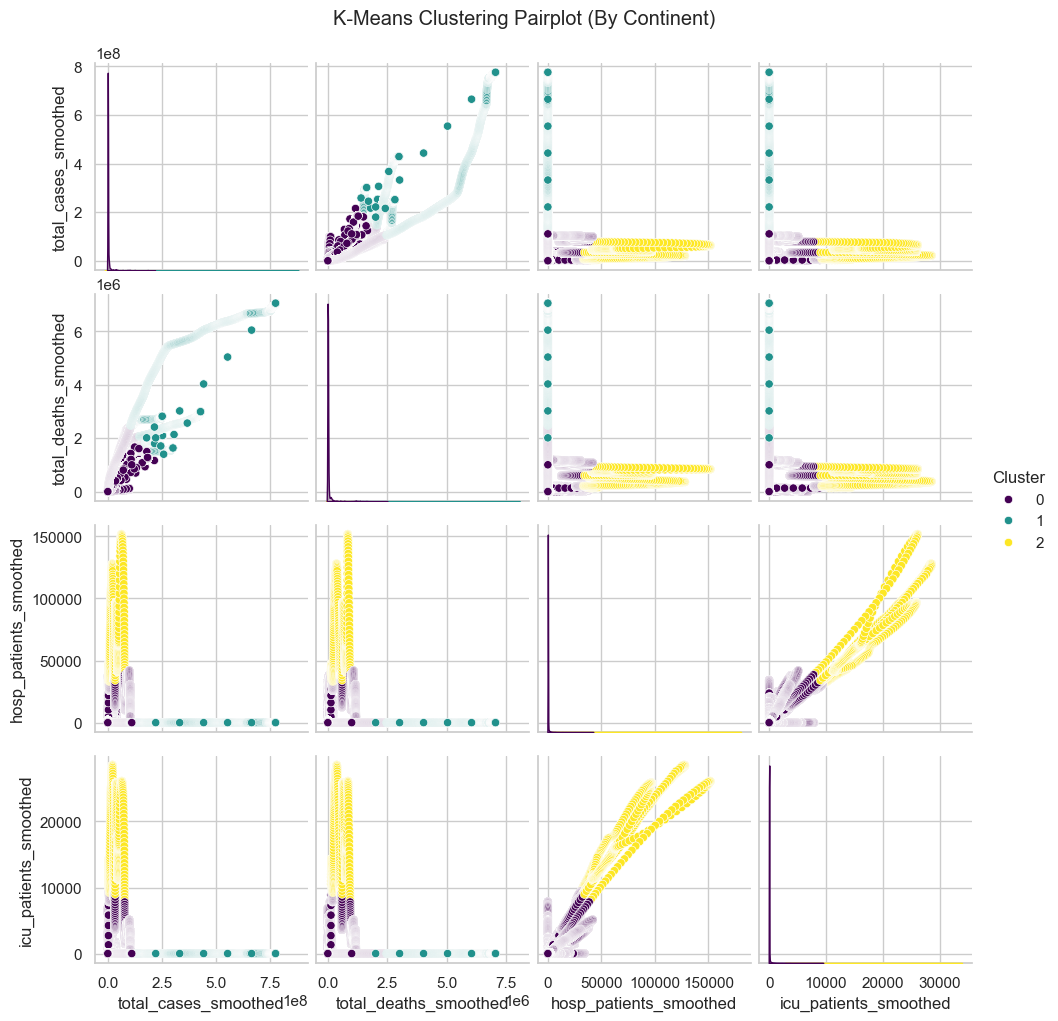


Cluster Sizes:
Cluster
0    424417
1      4572
2       446
Name: count, dtype: int64
Silhouette Score: 0.9521


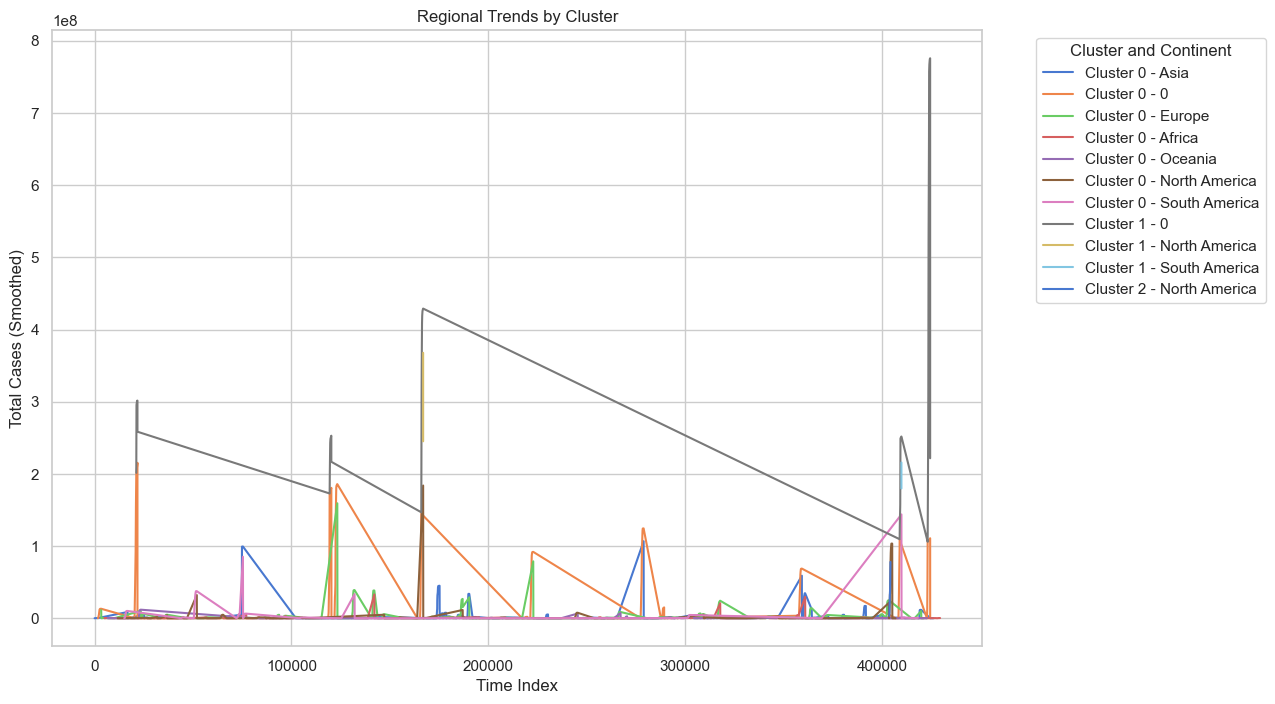

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set Seaborn style
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Load the dataset
df = pd.read_csv("owid_covid_data.csv")

# Data cleaning: Select relevant features and handle missing values
features = ['continent', 'total_cases', 'total_deaths', 'hosp_patients', 'icu_patients']
df_subset = df[features].fillna(0)  # Replace NaNs with 0

# Filter data for meaningful analysis (e.g., exclude rows with no continent information)
df_subset = df_subset[df_subset['continent'] != '']

# Apply rolling average for smoothing (7-day window)
columns_to_smooth = ['total_cases', 'total_deaths', 'hosp_patients', 'icu_patients']
for col in columns_to_smooth:
    df_subset[f'{col}_smoothed'] = df_subset[col].rolling(window=7).mean().bfill()

# Standardize the smoothed features (excluding continent)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset[[f'{col}_smoothed' for col in columns_to_smooth]])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
df_subset['Cluster'] = clusters

# Compute summary statistics for each cluster
cluster_summary = df_subset.groupby('Cluster')[[f'{col}_smoothed' for col in columns_to_smooth]].mean()
print("\nCluster Summary Statistics:")
print(cluster_summary)

# Visualize clusters using a pairplot
sns.pairplot(df_subset, vars=[f'{col}_smoothed' for col in columns_to_smooth], hue='Cluster', palette='viridis', diag_kind='kde', height=2.5)
plt.suptitle('K-Means Clustering Pairplot (By Continent)', y=1.02)
plt.show()

# Analyze cluster sizes and Silhouette Score
print("\nCluster Sizes:")
print(df_subset['Cluster'].value_counts())
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Visualize regional trends for each cluster
plt.figure(figsize=(12, 8))
for cluster_id in cluster_summary.index:
    cluster_data = df_subset[df_subset['Cluster'] == cluster_id]
    for continent in cluster_data['continent'].unique():
        continent_data = cluster_data[cluster_data['continent'] == continent]
        plt.plot(continent_data['total_cases_smoothed'], label=f"Cluster {cluster_id} - {continent}")
plt.title("Regional Trends by Cluster")
plt.xlabel("Time Index")
plt.ylabel("Total Cases (Smoothed)")
plt.legend(title="Cluster and Continent", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### Task 8: Advanced Clustering with DBSCAN
- Perform clustering on COVID-19 data using the DBSCAN algorithm to identify region with similar pandemic characteristics.
- Use features such as total_cases, total_deaths, hosp_patients, and icu_patients.
- Analyze cluster sizes, noise points, and feature distributions within each cluster.
- Visualize clustering results and time-series trends for each cluster.


Cluster Summary Statistics:
          total_cases  total_deaths  hosp_patients  icu_patients
Cluster                                                         
0        2.846281e+06  3.779700e+04     165.269752     25.332877
1        4.130253e+08  2.874214e+06       0.000000      0.000000
2        1.505786e+06  4.569377e+04   13629.925170   1574.455782
3        9.882756e+07  1.193862e+05       0.000000      0.000000
4        2.986883e+08  1.625938e+06       0.000000      0.000000
5        1.169183e+08  2.467204e+06       0.000000      0.000000
6        2.399608e+08  2.035141e+06       0.000000      0.000000
7        7.702427e+08  6.987414e+06       0.000000      0.000000
8        2.499078e+08  2.812809e+06       0.000000      0.000000
9        3.529193e+07  1.590672e+05   13993.350649    808.311688
10       9.975507e+07  1.104204e+06   22256.020408   2765.408163
11       2.275092e+06  7.164712e+04   25872.194805   2681.902597
12       2.346635e+07  1.400111e+05   20096.753247   1349.922

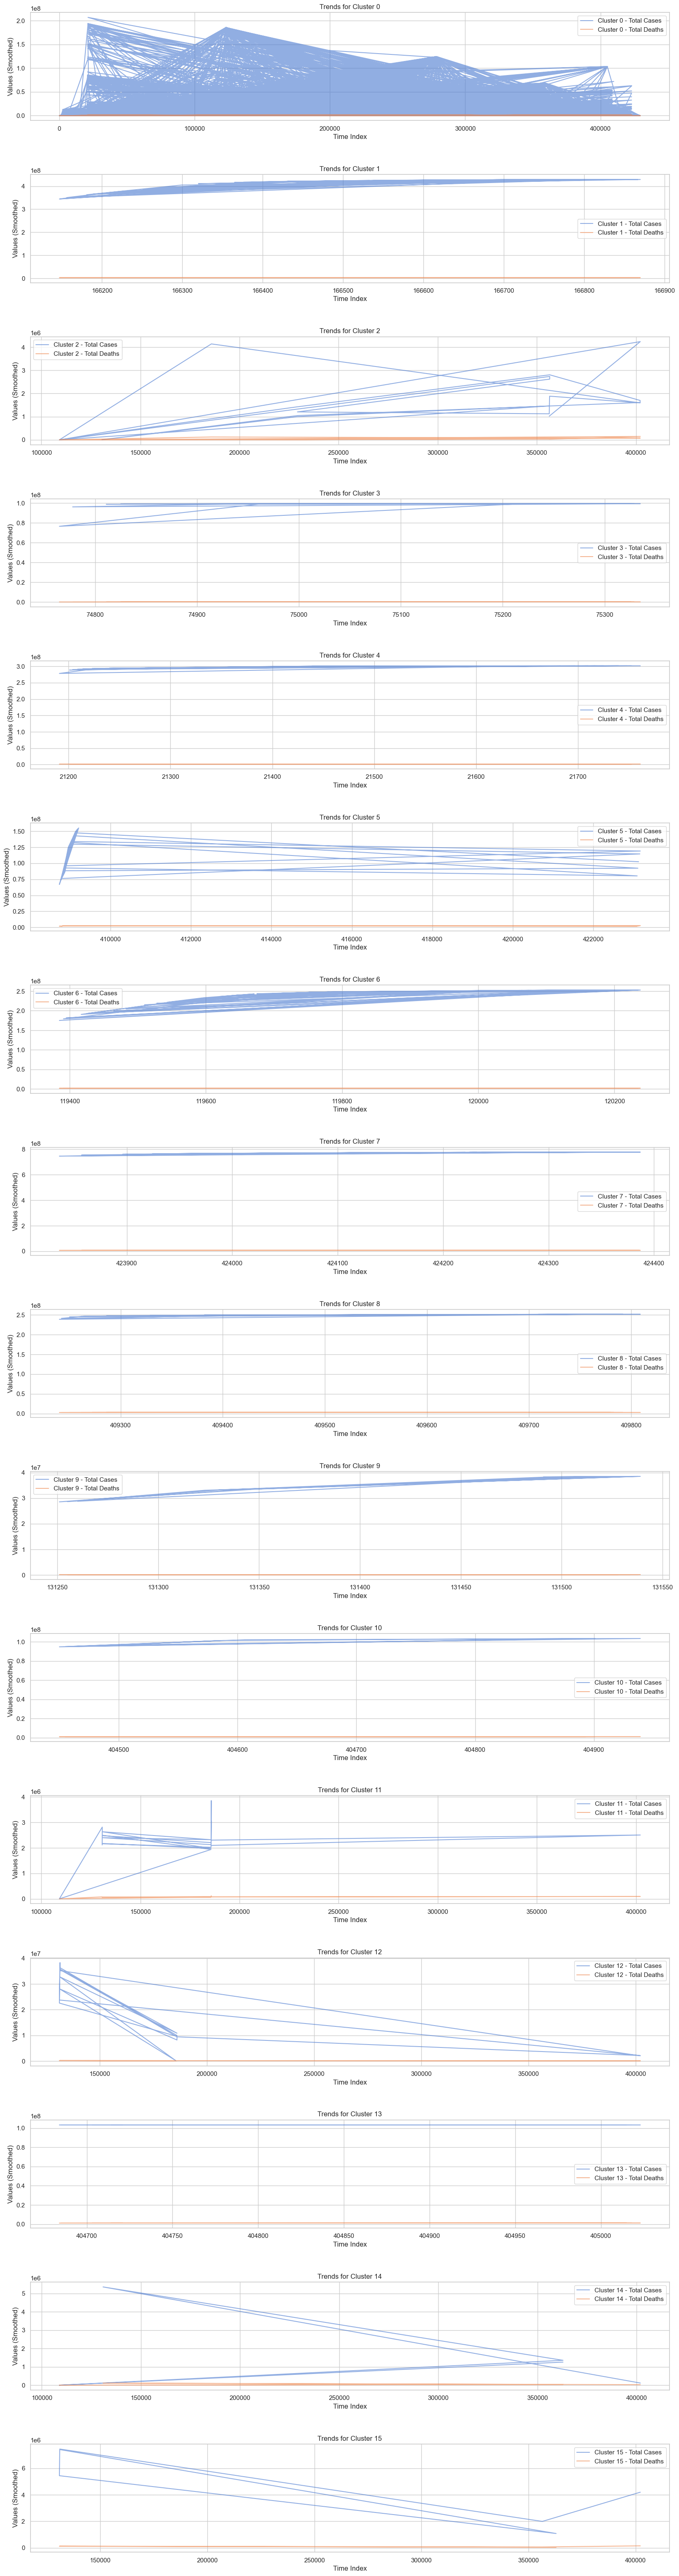


Cluster Sizes:
Cluster
0     42073
1        86
6        85
4        62
5        60
8        58
3        56
7        52
9        22
11       22
12       22
2        21
10       14
13       12
14       10
15        6
Name: count, dtype: int64


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Set Seaborn style
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Load the dataset
df = pd.read_csv("owid_covid_data.csv")

# Select relevant features for clustering
features = ['total_cases', 'total_deaths', 'hosp_patients', 'icu_patients']
df_subset = df[features].fillna(0)  # Replace missing values with 0

# Apply rolling average for smoothing (7-day window)
df_subset_rolling = df_subset.rolling(window=7).mean().bfill()

# Randomly sample 10% of the data to reduce computational load
df_sampled = df_subset_rolling.sample(frac=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sampled)

# Apply DBSCAN algorithm
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust eps and min_samples for better clustering
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels to the sampled DataFrame
df_sampled['Cluster'] = clusters

# Filter out noise points (-1) for cleaner analysis
df_filtered = df_sampled[df_sampled['Cluster'] != -1]

# Compute summary statistics for each cluster
cluster_summary = df_filtered.groupby('Cluster')[features].mean()
print("\nCluster Summary Statistics:")
print(cluster_summary)

# Create independent subplots for each cluster's trends
unique_clusters = cluster_summary.index

plt.figure(figsize=(20, 5 * len(unique_clusters)))  # Dynamically adjust figure size
for i, cluster_id in enumerate(unique_clusters):
    plt.subplot(len(unique_clusters), 1, i + 1)  # Create one subplot per cluster
    cluster_data = df_filtered[df_filtered['Cluster'] == cluster_id]
    plt.plot(cluster_data.index, cluster_data['total_cases'], alpha=0.6, label=f"Cluster {cluster_id} - Total Cases")
    plt.plot(cluster_data.index, cluster_data['total_deaths'], alpha=0.6, label=f"Cluster {cluster_id} - Total Deaths")
    plt.title(f"Trends for Cluster {cluster_id}")
    plt.xlabel("Time Index")
    plt.ylabel("Values (Smoothed)")
    plt.legend()
    plt.grid(True)

plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots
plt.show()

# Display cluster sizes
print("\nCluster Sizes:")
print(df_filtered['Cluster'].value_counts())

### Task 9: Time Series Forecasting Using Deep Learning
- Forecast key metrics (e.g., ICU requirements, total cases) using state-of-the-art time series models.
- Implement Long Short-Term Memory (LSTM) networks to capture temporal dependencies.
- Evaluate models using metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

2684/2684 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 1.5162e-06
Test Loss (MSE): 1.2295221267777379e-06
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step
Mean Absolute Error (MAE): 19.91633248297163
Root Mean Squared Error (RMSE): 31.866845003528304


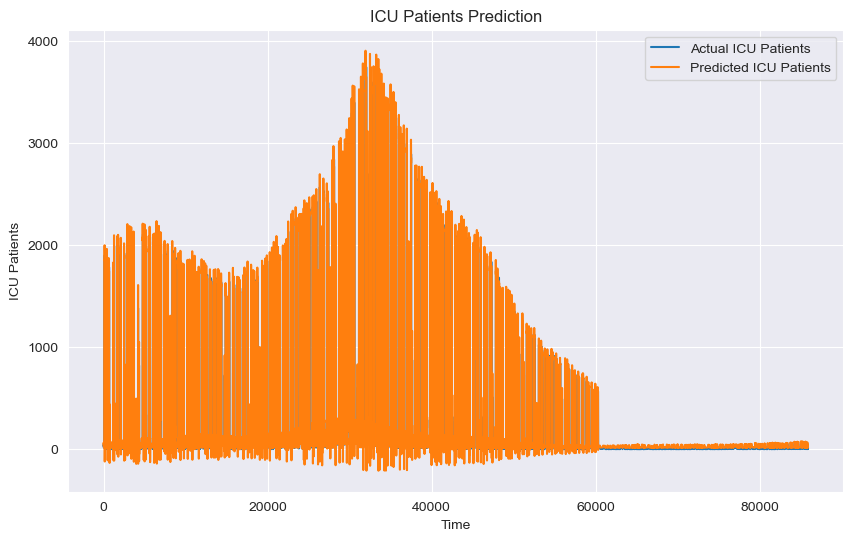

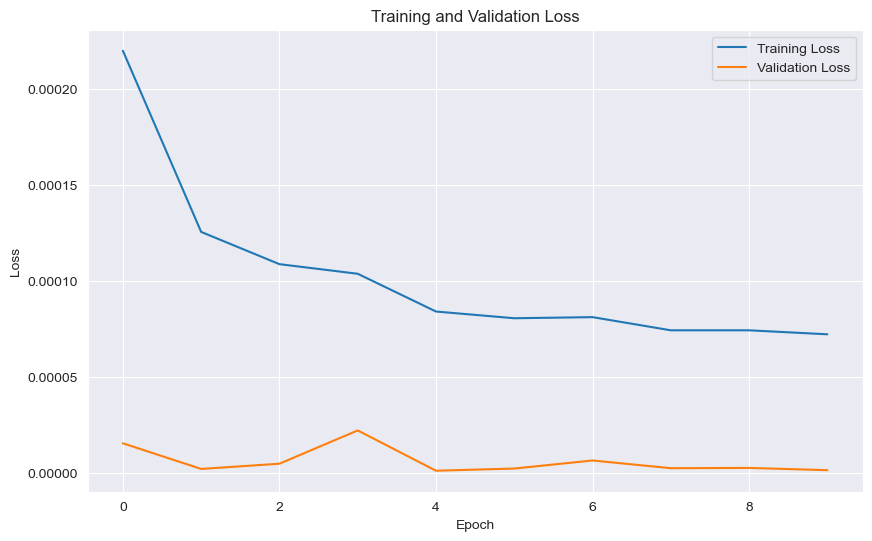

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the original dataset
df = pd.read_csv("owid_covid_data.csv")

# Select relevant columns and filter for ICU patients
columns = ['date', 'icu_patients']
df = df[columns]

# Convert date column to datetime and sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Handle missing values (fill forward)
df = df.ffill()

# Add 7-day rolling average for smoothing
df['icu_patients_smoothed'] = df['icu_patients'].rolling(window=7).mean().bfill()

# Normalize the smoothed ICU patients data
scaler = MinMaxScaler(feature_range=(0, 1))
df['icu_patients_scaled'] = scaler.fit_transform(df[['icu_patients_smoothed']])

# Prepare the data for time series forecasting
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Use the past 30 days to predict the next day
data = df['icu_patients_scaled'].values
X, y = create_sequences(data, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    Input(shape=(sequence_length, 1)),
    LSTM(128, return_sequences=True),  # Increased units to better learn patterns
    Dropout(0.3),  # Higher dropout to prevent overfitting
    LSTM(64, return_sequences=False),  # Reduced units in second layer for efficiency
    Dropout(0.3),
    Dense(1)  # Single output for ICU prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add callbacks: EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],  # Include callbacks
    verbose=1
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual ICU Patients')
plt.plot(predictions, label='Predicted ICU Patients')
plt.title('ICU Patients Prediction')
plt.xlabel('Time')
plt.ylabel('ICU Patients')
plt.legend()
plt.show()

# Visualize training process
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()